## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

## Import Tables

In [3]:
# Doug's Path
diagnoses_icd = pd.read_csv('../data/mimic-iv-0.4/hosp/diagnoses_icd.csv.gz', compression='gzip')
d_icd_diagnoses = pd.read_csv('../data/mimic-iv-0.4/hosp/d_icd_diagnoses.csv.gz', compression='gzip')
admissions = pd.read_csv('../data/mimic-iv-0.4/core/admissions.csv.gz', compression='gzip')
patients =  pd.read_csv('../data/mimic-iv-0.4/core/patients.csv.gz', compression='gzip')
d_labitems = pd.read_csv('../data/mimic-iv-0.4/hosp/d_labitems.csv.gz', compression='gzip')
drg_codes = pd.read_csv("../data/mimic-iv-0.4/hosp/drgcodes.csv.gz", compression='gzip')

# # Stephen's Path
# path = "D:\\Bootcamp\\MIMIC IV\\"
# admissions = pd.read_csv(path + "core\\admissions.csv.gz", compression='gzip')
# patients = pd.read_csv(path + "core\\patients.csv.gz", compression='gzip')
# diagnoses_icd = pd.read_csv(path + "hosp\\diagnoses_icd.csv.gz", compression='gzip')
# d_icd_diagnoses = pd.read_csv(path + "hosp\\d_icd_diagnoses.csv.gz", compression='gzip')
# d_labitems = pd.read_csv(path + "hosp\\d_labitems.csv.gz", compression='gzip')

## Table Cleanup

In [4]:
drg_codes = drg_codes.drop_duplicates().groupby('hadm_id').first().reset_index()
drg_codes.description = drg_codes.description.str.lower()
diagnoses_icd.icd_code = diagnoses_icd.icd_code.str.strip()

d_icd_diagnoses.icd_code = d_icd_diagnoses.icd_code.str.strip()
d_icd_diagnoses.long_title = d_icd_diagnoses.long_title.str.lower()

## Pull codes related to target Diagnosis

In [5]:
d_icd_diagnoses.long_title = d_icd_diagnoses.long_title.str.lower()

# Congestive Heart Failure
pos_codes = d_icd_diagnoses[(d_icd_diagnoses['long_title'].str.contains('heart failure'))]
pos_codes = pos_codes[~pos_codes.long_title.str.contains('without')]
pos_codes = list(map(str, pos_codes['icd_code']))

# kidney_list = list(d_icd_diagnoses[(d_icd_diagnoses['long_title'].str.lower().str.contains('kidney')) & (d_icd_diagnoses['long_title'].str.lower().str.contains('failure'))]['icd_code'])
# pd.DataFrame(diagnoses_icd[diagnoses_icd['icd_code'].isin(kidney_list)].icd_code.value_counts()).reset_index().head(20).merge(d_icd_diagnoses, left_index = True, left_on = "index", right_on = 'icd_code', how = 'left')

# ICD Codes we care about for AKI
# 5849, N179, 5845, N170
# pos_codes = ['5849   ', 'N179   ', '5845   ', 'N170   ']


## Start filtering down to only records where Diagnosis is Positive

In [6]:
diagnoses_icd_pos = diagnoses_icd[diagnoses_icd['icd_code'].isin(pos_codes)]


In [7]:
diagnoses_icd_pos.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
886,16569548,24870770,12,4280,9
896,16569548,24870770,7,42830,9
1040,18460230,25771608,1,42821,9
1050,18460230,25771608,2,4280,9
2342,19661870,22135027,3,4280,9


## Generate new Admissions table with hospital stay duration and Positive Diagnosis Flag

In [8]:
admissions_pos = admissions[['subject_id', 'hadm_id', 'admittime', 'dischtime', 'ethnicity']]

admissions_pos['pos_subj'] = np.where(admissions_pos.subject_id.isin(diagnoses_icd_pos.subject_id), 1, 0)
admissions_pos['pos_adm'] = np.where(admissions_pos.hadm_id.isin(diagnoses_icd_pos.hadm_id), 1, 0)
admissions_pos['time_spent'] = pd.to_datetime(admissions_pos['dischtime']) - pd.to_datetime(admissions_pos['admittime'])

admissions.edregtime = pd.to_datetime(admissions.edregtime)
admissions.edouttime = pd.to_datetime(admissions.edouttime)
admissions['ed_length']=np.where(admissions.edregtime.isna(),0,(admissions.edouttime-admissions.edregtime)/pd.offsets.Hour(1))

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to b

In [9]:
admissions_pos.head(10)

,subject_id,hadm_id,admittime,dischtime,ethnicity,pos_subj,pos_adm,time_spent
0,12427812,21593330,2184-01-06 11:51:00,2184-01-10 11:45:00,UNKNOWN,0,0,3 days 23:54:00
1,14029832,22059088,2120-01-18 01:28:00,2120-01-20 16:13:00,OTHER,0,0,2 days 14:45:00
2,14495017,22484010,2175-01-28 15:41:00,2175-01-29 16:00:00,WHITE,0,0,1 days 00:19:00
3,13676048,23865469,2193-01-19 05:27:00,2193-01-24 18:59:00,WHITE,0,0,5 days 13:32:00
4,13831972,27763544,2131-01-27 04:03:00,2131-01-27 05:39:00,WHITE,0,0,0 days 01:36:00
5,18523038,25414328,2142-08-26 17:14:00,2142-08-27 10:00:00,WHITE,0,0,0 days 16:46:00
6,16705931,20580522,2174-10-24 11:30:00,2174-10-24 18:45:00,WHITE,0,0,0 days 07:15:00
7,19963742,24951506,2171-07-04 15:58:00,2171-07-05 13:37:00,UNKNOWN,0,0,0 days 21:39:00
8,10903424,22568585,2181-01-31 13:09:00,2181-01-31 13:42:00,WHITE,0,0,0 days 00:33:00
9,15030422,21975876,2149-09-21 23:54:00,2149-09-22 03:59:00,WHITE,0,0,0 days 04:05:00


In [10]:
admissions_pos=admissions_pos.merge(patients, on='subject_id')
admissions_pos = admissions_pos[admissions_pos.gender=='F']
admissions_pos

,subject_id,hadm_id,admittime,dischtime,ethnicity,pos_subj,pos_adm,time_spent,gender,anchor_age,anchor_year,anchor_year_group,dod
0,12427812,21593330,2184-01-06 11:51:00,2184-01-10 11:45:00,UNKNOWN,0,0,3 days 23:54:00,F,35,2184,2017 - 2019,NaN
1,12427812,23948770,2185-01-20 00:08:00,2185-01-21 11:45:00,WHITE,0,0,1 days 11:37:00,F,35,2184,2017 - 2019,NaN
2,14029832,22059088,2120-01-18 01:28:00,2120-01-20 16:13:00,OTHER,0,0,2 days 14:45:00,F,55,2120,2017 - 2019,NaN
5,13676048,23865469,2193-01-19 05:27:00,2193-01-24 18:59:00,WHITE,0,0,5 days 13:32:00,F,33,2188,2014 - 2016,NaN
6,13831972,27763544,2131-01-27 04:03:00,2131-01-27 05:39:00,WHITE,0,0,0 days 01:36:00,F,46,2129,2008 - 2010,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
524514,16624205,23962991,2126-02-03 15:27:00,2126-03-18 16:15:00,OTHER,0,0,43 days 00:48:00,F,44,2126,2011 - 2013,NaN
524515,17137356,25525683,2125-01-28 18:59:00,2125-01-30 15:25:00,BLACK/AFRICAN AMERICAN,0,0,1 days 20:26:00,F,51,2125,2008 - 2010,NaN
524516,11043367,25542639,2153-06-06 23:14:00,2153-06-09 12:31:00,OTHER,0,0,2 days 13:17:00,F,30,2151,2008 - 2010,NaN
524517,11084272,25138318,2135-11-03 08:00:00,2135-11-07 14:26:00,OTHER,0,0,4 days 06:26:00,F,43,2135,2008 - 2010,NaN


## Sample Target Patients for Modeling

In [11]:
n_samples = 15000

target_sample = admissions_pos[['subject_id', 'pos_subj']].drop_duplicates()

target_sample = resample(target_sample, n_samples = n_samples, replace = False, stratify = target_sample.pos_subj, random_state = 0)


In [12]:
# identify first pos visit for NON-pos patients
sample_non = target_sample[target_sample.pos_subj==0]
admissions_non = admissions[admissions.subject_id.isin(sample_non.subject_id)]
admissions_non['admittime'] = pd.to_datetime(admissions_non.admittime)

select_random = lambda obj: obj.loc[np.random.choice(obj.index, 1, False),:]

first_non = admissions_non.groupby('subject_id').apply(select_random).reset_index(drop=True)
# sanity checks
print(first_non.shape)                 # number of rows
print(first_non.subject_id.nunique())  # matches number of patients
print(first_non.hadm_id.nunique())     # matches number of visits

# pull out hospital visits for target non-pos samples
sample_non = sample_non.merge(first_non, how='inner', on='subject_id')
sample_non = sample_non[['subject_id', 'hadm_id', 'pos_subj']]
sample_non = sample_non.rename({'pos_subj':'pos'}, axis=1)

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(13808, 16)
13808
13808


In [13]:
# identify first pos visit for all pos patients
sample_pos = target_sample[target_sample.pos_subj==1]
first_pos = admissions_pos[admissions_pos.subject_id.isin(sample_pos.subject_id)]
first_pos['admittime'] = pd.to_datetime(first_pos.admittime)
first_pos = first_pos.loc[first_pos[first_pos.pos_adm==1].groupby('subject_id').admittime.idxmin()]
first_pos = first_pos[['subject_id', 'hadm_id', 'pos_adm']]
# sanity checks
print(np.mean(first_pos.pos_adm))   # make sure everyone has pos
print(first_pos.shape)                 # make sure number of rows...
print(first_pos.subject_id.nunique())  # ...matches number of patients
print(first_pos.hadm_id.nunique())     # ...matches number of visits

# pull out hospital visits for target pos samples
sample_pos = sample_pos.merge(first_pos, how='inner', on='subject_id')
sample_pos = sample_pos[['subject_id', 'hadm_id', 'pos_adm']]
sample_pos = sample_pos.rename({'pos_adm':'pos'}, axis=1)

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


1.0
(1192, 3)
1192
1192


In [14]:
# merge back together
admissions_sample = pd.concat([sample_pos, sample_non])
admissions_sample = admissions_sample.reset_index(drop=True)
print(admissions_sample.shape)                  # sanity check
print(admissions_sample.subject_id.nunique())   # sanity check

(15000, 3)
15000


In [15]:
# merge features from other tables
admissions_sample = admissions_sample.merge(admissions[['hadm_id', 'ethnicity','ed_length','insurance']], how='left', on='hadm_id')
admissions_sample = admissions_sample.merge(patients[['subject_id', 'gender', 'anchor_age']], how='left', on='subject_id')

# basic data cleaning
admissions_sample.loc[admissions_sample.ethnicity=='UNABLE TO OBTAIN', 'ethnicity'] = 'UNKNOWN'  # combine unkown
admissions_sample = admissions_sample.rename(columns={'anchor_age':'age'})
admissions_sample = admissions_sample[admissions_sample.age > 0]   # remove children

Text(0.5, 1.0, 'Age Distribution')

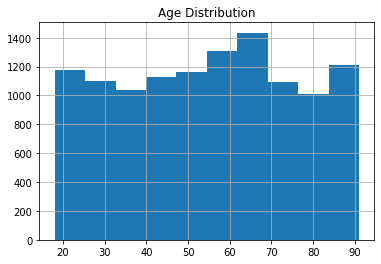

In [16]:
admissions_sample.age.hist()
plt.title('Age Distribution')

Text(0.5, 1.0, 'Gender Distribution')

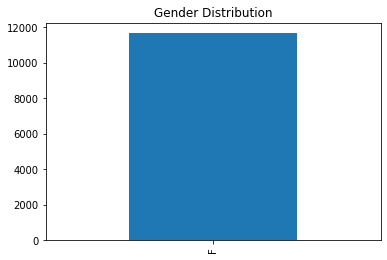

In [17]:
admissions_sample.gender.value_counts().plot(kind='bar')
plt.title('Gender Distribution')

Text(0.5, 1.0, 'Ethnicity Distribution')

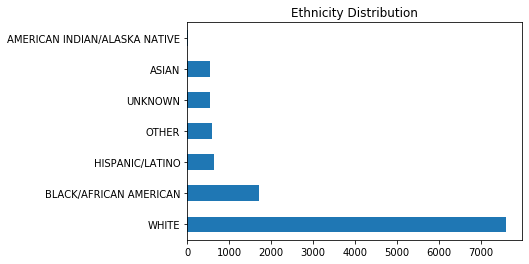

In [18]:
admissions_sample.ethnicity.value_counts().plot(kind='barh')
plt.title('Ethnicity Distribution')

In [19]:
print('Number of unique Patients: ', target_sample.subject_id.nunique())
print('\nSample Breakdown:')
print(target_sample.pos_subj.value_counts())

Number of unique Patients:  15000

Sample Breakdown:
0    13808
1     1192
Name: pos_subj, dtype: int64


## Add Comorbidities to Sample Table

In [20]:
adm_date = admissions_sample.merge(admissions[['hadm_id', 'admittime']], on = 'hadm_id')

admissions.admittime = pd.to_datetime(admissions.admittime)
admissions.dischtime = pd.to_datetime(admissions.dischtime)

subj_admissions = admissions.loc[(admissions.subject_id.isin(adm_date.subject_id.unique()))]
subj_admissions = subj_admissions.sort_values(['subject_id', 'admittime']).reset_index(drop=True)
subj_admissions['sample_adm'] = np.where(subj_admissions.hadm_id.isin(admissions_sample.hadm_id), 1, 0)

sample_idx = subj_admissions[subj_admissions.sample_adm==1].index

sample_admission = subj_admissions.iloc[sample_idx].reset_index(drop=True)
prior_admission = subj_admissions.iloc[sample_idx-1].reset_index(drop=True)

prior_index = (sample_admission['subject_id'] == prior_admission['subject_id']) & ((sample_admission['admittime'] - prior_admission['dischtime']) < pd.to_timedelta('1095 days'))

sample_hadm = prior_admission['hadm_id']

s_drg = drg_codes[drg_codes.hadm_id.isin(sample_hadm)][['hadm_id', 'description']]
comorbidities =  ['sepsis', 'pneumoia', 'diabetes', 'hypertension',\
              'renal failure', 'kidney failure',\
              'atrial fibrillation', 'atherosclero', 'cardiac arrhythmia']
# come back for "vascular procedures", "coronary bypass", "cardiac congenital"
for comorb in comorbidities:
    s_drg[comorb] =  np.where(s_drg.description.str.contains(comorb), 1, 0)

s_icd = diagnoses_icd[diagnoses_icd.hadm_id.isin(sample_hadm)][['hadm_id', 'icd_version', 'icd_code']]
s_icd = s_icd.merge(d_icd_diagnoses, how='left', on=['icd_version', 'icd_code'])
s_icd = s_icd.drop(['icd_code', 'icd_version'], axis=1)
s_icd = s_icd.groupby('hadm_id').agg(description=('long_title', lambda x: ''.join(str(x).rstrip()))).reset_index()
for comorb in comorbidities:
    s_icd[comorb] =  np.where(s_icd.description.str.contains(comorb), 1, 0)

s_comorb = pd.merge(s_drg, s_icd, how='outer', on='hadm_id').fillna(0)
for co_ in comorbidities:
    s_comorb[co_] = s_comorb[co_+'_x'] + s_comorb[co_+'_y']
    s_comorb[co_] = np.where(s_comorb[co_] > 0, 1, 0)
    s_comorb = s_comorb.drop([co_+'_x', co_+'_y'], axis=1)
s_comorb['renal_failure'] = np.where((s_comorb['renal failure'] + s_comorb['kidney failure']) > 1, 1, 0)
s_comorb['arrhythmia'] = np.where((s_comorb['atrial fibrillation'] + s_comorb['cardiac arrhythmia']) > 1, 1, 0)
s_comorb = s_comorb.drop(['kidney failure', 'renal failure', 'atrial fibrillation', 'cardiac arrhythmia',\
                   'description_x', 'description_y'], axis=1)

prior_admission = prior_admission.merge(s_comorb, how='left', on='hadm_id').fillna(0)

prior_admission_trimmed = prior_admission.loc[prior_index][['sepsis', 'pneumoia', 'diabetes', 'hypertension', 'atherosclero', 'renal_failure', 'arrhythmia']]

sample_admission = sample_admission.merge(prior_admission_trimmed, how = 'left', left_index = True, right_index = True).fillna(0)

admissions_sample = admissions_sample.merge(sample_admission[['hadm_id', 'pneumoia', 'diabetes', 'hypertension', 'atherosclero', 'renal_failure', 'arrhythmia']], on = 'hadm_id')


Generate pickle file so we all work on the exact same data

In [24]:
admissions_sample.to_pickle('../data/admissions_sample_female.pkl')

In [ ]:
# admissions_sample = pd.read_pickle("admissions_sample.pkl")